In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import joblib

# Set up matplotlib for inline plotting
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Download NLTK data and define preprocessing function
# Download NLTK stopwords if not already downloaded
try:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    print("NLTK stopwords downloaded successfully!")
except:
    stop_words = set()
    print("Using empty stopwords set")

# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

print("Preprocessing function defined!")

NLTK stopwords downloaded successfully!
Preprocessing function defined!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset Info:
Shape: (10000, 4)
Columns: ['id', 'sender', 'message_body', 'category']

Category Distribution:
category
promotion    2445
banking      2148
otp          2002
service      1938
personal     1018
spam          449
Name: count, dtype: int64


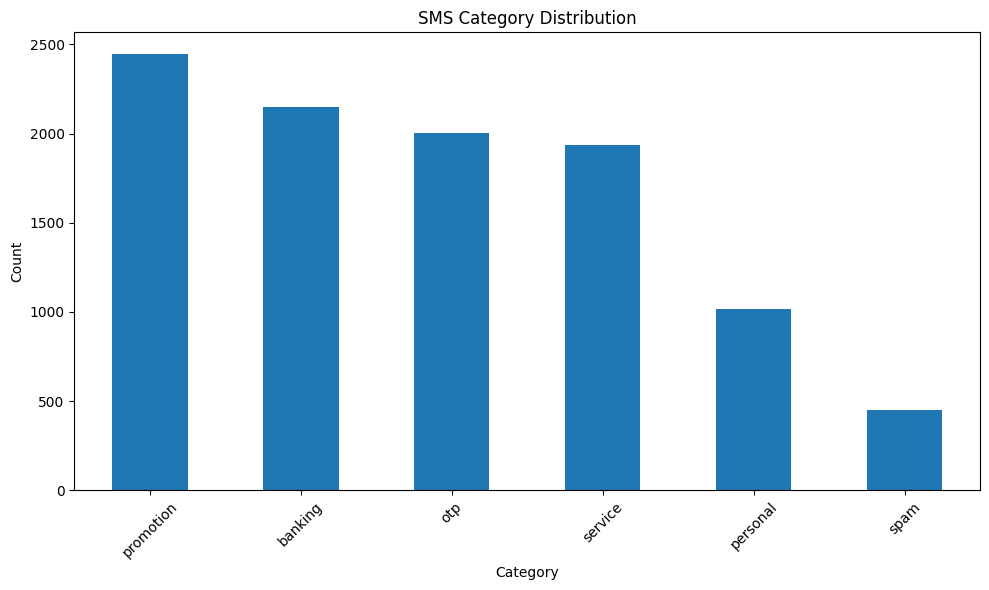


Sample data:


,id,sender,message_body,category
0,1,VERIFY,Your OTP is 047182 for login. Do not share it ...,otp
1,2,AXISBK,Your Rs 9800.00 transfer to Suresh is successf...,banking
2,3,ZOMATO,Your order 12345 is on the way. ETA 25 mins. C...,promotion
3,4,91-9876543210,"Hey yaar, long time! U coming to the get-toget...",personal
4,5,OTPSMS,Use 826493 to verify your login. Exp 10 mins. ...,otp



Missing values:
id              0
sender          1
message_body    0
category        0
dtype: int64


In [4]:
# Cell 3: Load and explore the dataset
# Load the dataset
df = pd.read_csv('sms_dataset_10k.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display category distribution
print("\nCategory Distribution:")
category_counts = df['category'].value_counts()
print(category_counts)

# Visualize category distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('SMS Category Distribu  tion')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSample data:")
display(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

In [5]:
# Cell 4: Preprocess text data
print("Preprocessing text data...")
df['cleaned_message'] = df['message_body'].apply(preprocess_text)

# Show some examples of cleaned text
print("\nOriginal vs Cleaned Text Examples:")
for i in range(3):
    print(f"Original: {df['message_body'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_message'].iloc[i]}")
    print("-" * 50)

Preprocessing text data...

Original vs Cleaned Text Examples:
Original: Your OTP is 047182 for login. Do not share it with anyone. ₹1200 charge alert program....
Cleaned: otp login share anyone ₹ charge alert program
--------------------------------------------------
Original: Your Rs 9800.00 transfer to Suresh is successful. Ref: AX-7842. Thanks for banking with us....
Cleaned: rs transfer suresh successful ref ax thanks banking us
--------------------------------------------------
Original: Your order 12345 is on the way. ETA 25 mins. Cash on delivery? ₹50 delivery charge included....
Cleaned: order way eta mins cash delivery ₹ delivery charge included
--------------------------------------------------


In [6]:
# Cell 5: Encode target variable and create features
# Encode the target variable
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

print(f"Category mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Feature extraction using TF-IDF
print("\nExtracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X = tfidf_vectorizer.fit_transform(df['cleaned_message'])
y = df['category_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Category mapping: {'banking': np.int64(0), 'otp': np.int64(1), 'personal': np.int64(2), 'promotion': np.int64(3), 'service': np.int64(4), 'spam': np.int64(5)}

Extracting features using TF-IDF...
Feature matrix shape: (10000, 5000)
Number of features: 5000


In [7]:
# Cell 6: Split the data
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training set size: 8000
Test set size: 2000
Training features shape: (8000, 5000)
Test features shape: (2000, 5000)


In [8]:
# Cell 7: Initialize and train models
# Initialize models with probability support
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
best_model = None
best_accuracy = 0

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }

    print(f"{name} Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = name

print(f"\nBest model: {best_model} with accuracy: {best_accuracy:.4f}")

Training models...

Training Random Forest...
Random Forest Accuracy: 0.9105
Training SVM...
SVM Accuracy: 0.9200
Training Logistic Regression...
Logistic Regression Accuracy: 0.9165

Best model: SVM with accuracy: 0.9200


Detailed Classification Report for SVM:
              precision    recall  f1-score   support

     banking       0.92      0.97      0.94       430
         otp       1.00      0.99      1.00       400
    personal       0.94      0.75      0.84       204
   promotion       0.92      0.96      0.94       489
     service       0.83      0.87      0.85       387
        spam       0.91      0.74      0.82        90

    accuracy                           0.92      2000
   macro avg       0.92      0.88      0.90      2000
weighted avg       0.92      0.92      0.92      2000



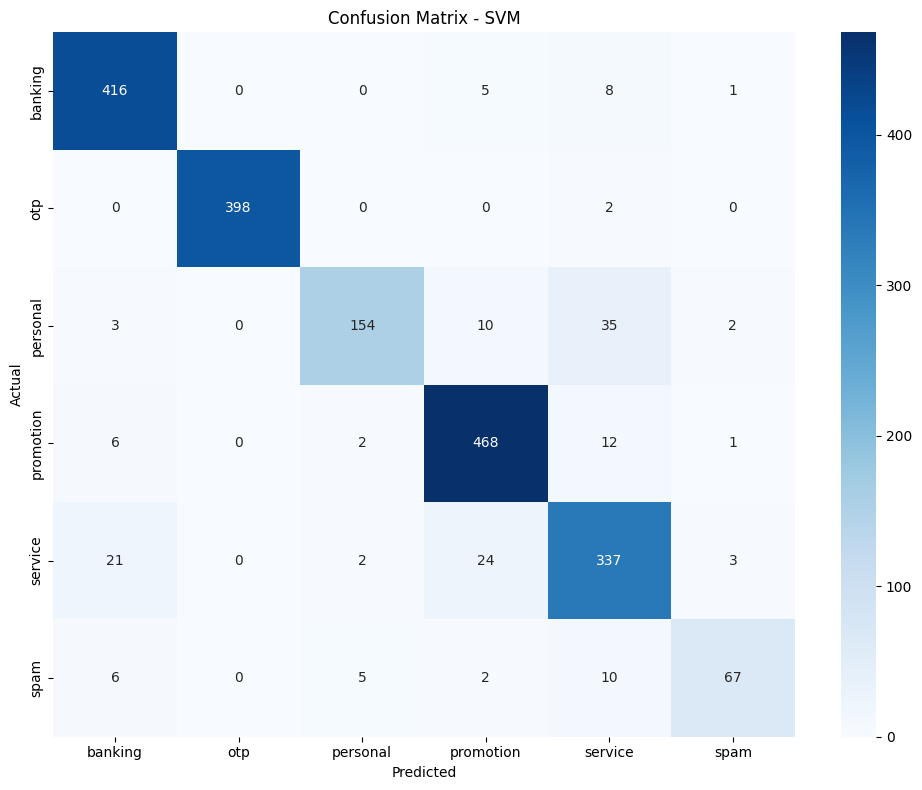

In [9]:
# Cell 8: Evaluate best model
best_model_info = results[best_model]
print(f"Detailed Classification Report for {best_model}:")
print(classification_report(y_test, best_model_info['predictions'],
                          target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_model_info['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [10]:
# Cell 9: Feature importance (if Random Forest is best model)
if best_model == 'Random Forest':
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = best_model_info['model'].feature_importances_
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12, 8))
    plt.title("Top 20 Important Features for SMS Classification")
    bars = plt.bar(range(20), importances[indices[:20]])
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
    plt.ylabel('Feature Importance')
    plt.tight_layout()
    plt.show()

    # Print top features
    print("Top 10 most important features:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    print(f"Feature importance visualization is available for Random Forest. Current best model is {best_model}.")


Feature importance visualization is available for Random Forest. Current best model is SVM.


In [11]:
# Cell 10: Define prediction function
# Enhanced prediction function that handles all models
def predict_message(message, model, vectorizer, label_encoder):
    cleaned_message = preprocess_text(message)
    features = vectorizer.transform([cleaned_message])
    prediction_encoded = model.predict(features)[0]

    # Check if model supports predict_proba
    if hasattr(model, 'predict_proba'):
        prediction_proba = model.predict_proba(features)[0]
        confidence = prediction_proba[prediction_encoded]
        probabilities = dict(zip(label_encoder.classes_, prediction_proba))
    else:
        # For models without probability, use decision function or set confidence to 1.0
        confidence = 1.0
        probabilities = {label: 1.0 if i == prediction_encoded else 0.0
                        for i, label in enumerate(label_encoder.classes_)}

    prediction = label_encoder.inverse_transform([prediction_encoded])[0]

    return prediction, confidence, probabilities

print("Prediction function defined!")

Prediction function defined!


In [12]:
# Cell 11: Test the model with sample messages
test_messages = [
    "Your OTP is 123456 for login. Do not share it with anyone.",
    "Congratulations! You've won a prize. Click here to claim.",
    "Your order #12345 is confirmed. Delivery in 30 mins.",
    "Your account balance is Rs. 5000. Last transaction: Rs. 200.",
    "Hey, are we meeting tomorrow for lunch?",
    "Your flight has been delayed by 2 hours.",
    "Get 50% off on all products. Limited time offer!",
    "Your card was used for Rs. 1500 at Amazon. If not you, call bank."
]

print("Testing the model with sample messages:\n")
for i, message in enumerate(test_messages, 1):
    prediction, confidence, all_probs = predict_message(
        message,
        best_model_info['model'],
        tfidf_vectorizer,
        label_encoder
    )
    print(f"{i}. Message: {message}")
    print(f"   Prediction: {prediction} (Confidence: {confidence:.4f})")

    # Show top 3 probabilities
    top_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"   Top probabilities: {top_probs}")
    print()

Testing the model with sample messages:

1. Message: Your OTP is 123456 for login. Do not share it with anyone.
   Prediction: otp (Confidence: 1.0000)
   Top probabilities: [('otp', np.float64(0.9999997830495886)), ('spam', np.float64(7.944165392840414e-08)), ('service', np.float64(7.210611118478585e-08))]

2. Message: Congratulations! You've won a prize. Click here to claim.
   Prediction: spam (Confidence: 0.9983)
   Top probabilities: [('spam', np.float64(0.998271832219607)), ('service', np.float64(0.000727737525736519)), ('personal', np.float64(0.0006371185746119871))]

3. Message: Your order #12345 is confirmed. Delivery in 30 mins.
   Prediction: promotion (Confidence: 0.9977)
   Top probabilities: [('promotion', np.float64(0.9976981376375865)), ('service', np.float64(0.002183930199163292)), ('spam', np.float64(0.0001105106761736314))]

4. Message: Your account balance is Rs. 5000. Last transaction: Rs. 200.
   Prediction: banking (Confidence: 0.9979)
   Top probabilities: [('ba

In [13]:
# Cell 12: Save the model
# Save the model and preprocessing objects
model_data = {
    'model': best_model_info['model'],
    'vectorizer': tfidf_vectorizer,
    'label_encoder': label_encoder,
    'preprocessing_function': preprocess_text,
    'best_model_name': best_model
}

joblib.dump(model_data, 'sms_classifier_model.pkl')
print("Model saved as 'sms_classifier_model.pkl'")
print(f"Best model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f}")


Model saved as 'sms_classifier_model.pkl'
Best model: SVM
Accuracy: 0.9200


In [14]:
# Cell 13: Test loading the model
# Load and use the model (example)
def load_and_predict(message, model_path='sms_classifier_model.pkl'):
    model_data = joblib.load(model_path)
    prediction, confidence, probabilities = predict_message(
        message,
        model_data['model'],
        model_data['vectorizer'],
        model_data['label_encoder']
    )
    return prediction, confidence, probabilities

# Test loading and prediction
print("Testing loaded model:")
test_msg = "Your verification code is 789012 for secure login."
prediction, confidence, probabilities = load_and_predict(test_msg)
print(f"Message: {test_msg}")
print(f"Prediction: {prediction} (Confidence: {confidence:.4f})")

# Show all probabilities
print("\nAll probabilities:")
for category, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {prob:.4f}")

Testing loaded model:
Message: Your verification code is 789012 for secure login.
Prediction: otp (Confidence: 0.9993)

All probabilities:
  otp: 0.9993
  spam: 0.0003
  service: 0.0003
  personal: 0.0001
  promotion: 0.0000
  banking: 0.0000


In [15]:
# Cell 14: Analyze misclassified examples (Simplified version)
print("Analyzing misclassified examples...")
y_pred_all = best_model_info['model'].predict(X_test)
misclassified_indices = np.where(y_pred_all != y_test)[0]

if len(misclassified_indices) > 0:
    print(f"\nFound {len(misclassified_indices)} misclassified examples")
    print(f"Showing first 5 misclassified examples:\n")

    misclassified_df = pd.DataFrame(columns=['Actual', 'Predicted', 'Message'])

    # Since we can't directly map back to original DataFrame indices,
    # we'll use the y_test indices which are from the original DataFrame
    for i, idx in enumerate(misclassified_indices[:5]):
        actual = label_encoder.inverse_transform([y_test.iloc[idx]])[0]
        predicted = label_encoder.inverse_transform([y_pred_all[idx]])[0]

        # Get the original message using the y_test index
        original_df_index = y_test.index[idx]
        original_message = df.loc[original_df_index, 'message_body']

        misclassified_df.loc[i] = [actual, predicted, original_message[:100] + "..."]

        print(f"{i+1}. Actual: {actual}, Predicted: {predicted}")
        print(f"   Message: {original_message[:100]}...")
        print()

    # Display as DataFrame for better readability
    display(misclassified_df)

    # Show misclassification rate
    misclassification_rate = len(misclassified_indices) / len(y_test)
    print(f"Misclassification rate: {misclassification_rate:.4f} ({len(misclassified_indices)}/{len(y_test)})")

else:
    print("No misclassified examples found!")

Analyzing misclassified examples...

Found 160 misclassified examples
Showing first 5 misclassified examples:

1. Actual: service, Predicted: promotion
   Message: Sunshine Supermarket - Your order 9876 placed. Pay on delivery. Total ₹850....

2. Actual: spam, Predicted: service
   Message: You have received a new message from 995... Confirm to view....

3. Actual: service, Predicted: promotion
   Message: Delivery delayed. Order #AMZ4567; refund of Rs 200 initiated. ETA 2 days....

4. Actual: spam, Predicted: personal
   Message: Hey, wassup? Free cricket tickets this weekend if you sign up now!...

5. Actual: personal, Predicted: service
   Message: Your ride to airport is confirmed. Driver ETA 8 mins. Car 7S9, plate KA01XYZ...



,Actual,Predicted,Message
0,service,promotion,Sunshine Supermarket - Your order 9876 placed....
1,spam,service,You have received a new message from 995... Co...
2,service,promotion,Delivery delayed. Order #AMZ4567; refund of Rs...
3,spam,personal,"Hey, wassup? Free cricket tickets this weekend..."
4,personal,service,Your ride to airport is confirmed. Driver ETA ...


Misclassification rate: 0.0800 (160/2000)


In [16]:
# Cell 15: Interactive testing (optional)
# Interactive cell for testing custom messages
print("Interactive Testing - Enter your own messages to classify:")
print("Type 'quit' to exit\n")

while True:
    user_input = input("Enter a message to classify: ")
    if user_input.lower() == 'quit':
        break

    if user_input.strip():
        prediction, confidence, probabilities = predict_message(
            user_input,
            best_model_info['model'],
            tfidf_vectorizer,
            label_encoder
        )
        print(f"Prediction: {prediction} (Confidence: {confidence:.4f})")

        # Show top 3 probabilities
        top_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"Top probabilities: {top_probs}")
        print("-" * 50)
    else:
        print("Please enter a valid message.")

Interactive Testing - Enter your own messages to classify:
Type 'quit' to exit

Enter a message to classify: hey Man 
Prediction: personal (Confidence: 0.9992)
Top probabilities: [('personal', np.float64(0.9992058303612666)), ('spam', np.float64(0.0006573564243702449)), ('service', np.float64(7.078966461165669e-05))]
--------------------------------------------------
Enter a message to classify: otp is 2382
Prediction: otp (Confidence: 1.0000)
Top probabilities: [('otp', np.float64(0.9999997912515606)), ('service', np.float64(8.258108025650808e-08)), ('spam', np.float64(5.697556606747571e-08))]
--------------------------------------------------
Enter a message to classify: you have won a car , click this link
Prediction: spam (Confidence: 0.9270)
Top probabilities: [('spam', np.float64(0.927019085936291)), ('service', np.float64(0.04600200189946728)), ('personal', np.float64(0.016206420638734814))]
--------------------------------------------------


KeyboardInterrupt: Interrupted by user

In [17]:
# Cell 16: Comprehensive Model Performance Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

print("=" * 60)
print("COMPREHENSIVE MODEL PERFORMANCE METRICS")
print("=" * 60)

# Get predictions
y_pred = best_model_info['predictions']

# Calculate overall metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nOVERALL METRICS:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Per-class metrics
print(f"\nPER-CLASS METRICS:")
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

for category in label_encoder.classes_:
    metrics = class_report[category]
    print(f"\n{category.upper():<12}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1-score']:.4f}")
    print(f"  Support:   {metrics['support']}")

# Macro and Weighted averages
print(f"\nAVERAGE METRICS:")
print(f"Macro Average Precision:  {class_report['macro avg']['precision']:.4f}")
print(f"Macro Average Recall:     {class_report['macro avg']['recall']:.4f}")
print(f"Macro Average F1-Score:   {class_report['macro avg']['f1-score']:.4f}")
print(f"Weighted Average Precision: {class_report['weighted avg']['precision']:.4f}")
print(f"Weighted Average Recall:    {class_report['weighted avg']['recall']:.4f}")
print(f"Weighted Average F1-Score:  {class_report['weighted avg']['f1-score']:.4f}")

# Performance Summary
print(f"\nPERFORMANCE SUMMARY:")
print(f"Best Model: {best_model}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correct Predictions: {np.sum(y_pred == y_test)}")
print(f"Misclassified: {np.sum(y_pred != y_test)}")
print(f"Accuracy: {accuracy:.2%}")

COMPREHENSIVE MODEL PERFORMANCE METRICS

OVERALL METRICS:
Accuracy:  0.9200
Precision: 0.9212
Recall:    0.9200
F1-Score:  0.9189

PER-CLASS METRICS:

BANKING     
  Precision: 0.9204
  Recall:    0.9674
  F1-Score:  0.9433
  Support:   430.0

OTP         
  Precision: 1.0000
  Recall:    0.9950
  F1-Score:  0.9975
  Support:   400.0

PERSONAL    
  Precision: 0.9448
  Recall:    0.7549
  F1-Score:  0.8392
  Support:   204.0

PROMOTION   
  Precision: 0.9194
  Recall:    0.9571
  F1-Score:  0.9379
  Support:   489.0

SERVICE     
  Precision: 0.8342
  Recall:    0.8708
  F1-Score:  0.8521
  Support:   387.0

SPAM        
  Precision: 0.9054
  Recall:    0.7444
  F1-Score:  0.8171
  Support:   90.0

AVERAGE METRICS:
Macro Average Precision:  0.9207
Macro Average Recall:     0.8816
Macro Average F1-Score:   0.8978
Weighted Average Precision: 0.9212
Weighted Average Recall:    0.9200
Weighted Average F1-Score:  0.9189

PERFORMANCE SUMMARY:
Best Model: SVM
Total Test Samples: 2000
Correct 

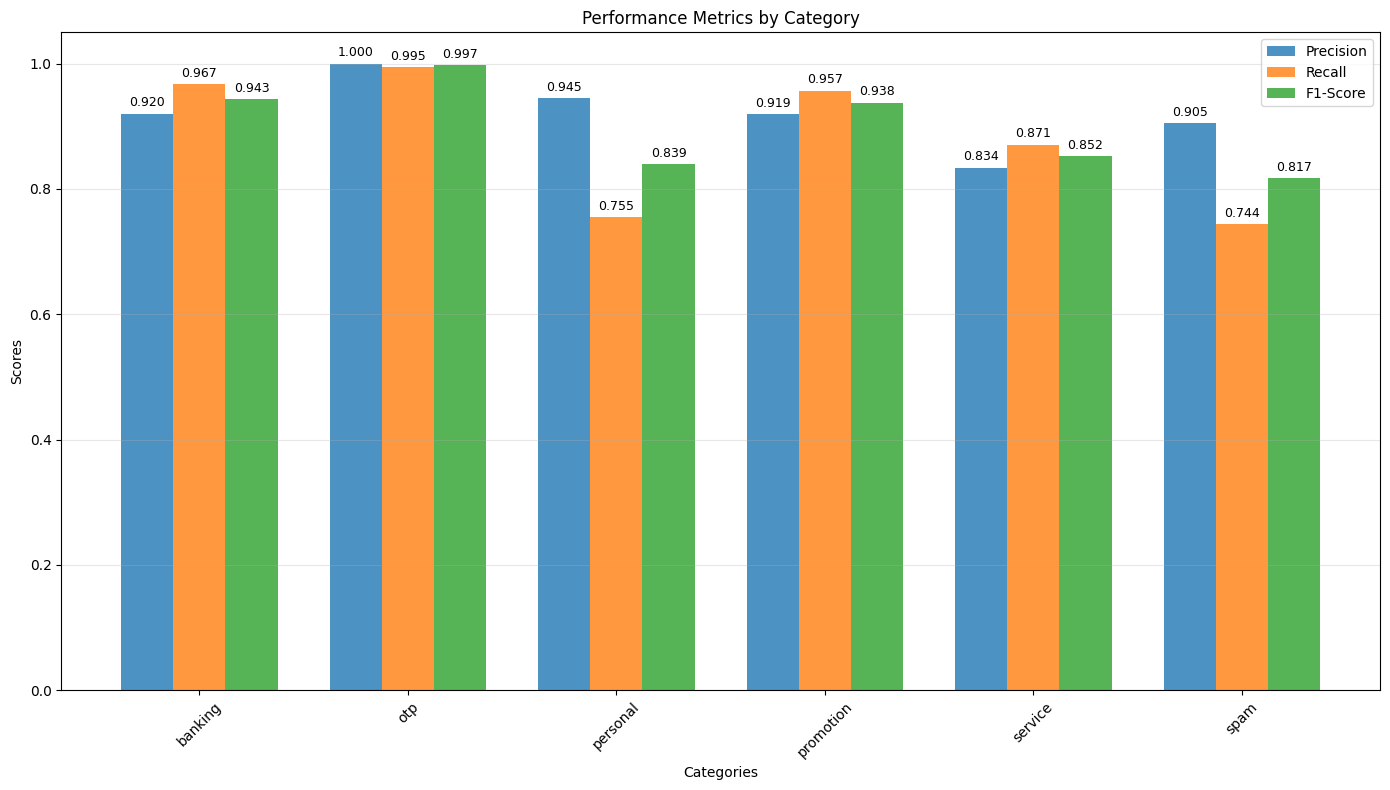

In [18]:
# Cell 17: Visualize Performance Metrics
# Create a performance summary chart
categories = label_encoder.classes_
precision_scores = [class_report[cat]['precision'] for cat in categories]
recall_scores = [class_report[cat]['recall'] for cat in categories]
f1_scores = [class_report[cat]['f1-score'] for cat in categories]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_scores, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Categories')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
# Cell 18: Model Performance Analysis
print("=" * 60)
print("MODEL PERFORMANCE ANALYSIS")
print("=" * 60)

# Calculate class-wise accuracy
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print(f"\nCLASS-WISE ACCURACY:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category:<12}: {class_accuracy[i]:.4f} ({class_accuracy[i]:.2%})")

# Most challenging categories (lowest F1-scores)
challenging_categories = sorted(
    [(cat, class_report[cat]['f1-score']) for cat in label_encoder.classes_],
    key=lambda x: x[1]
)

print(f"\nMOST CHALLENGING CATEGORIES (Lowest F1-Score):")
for cat, score in challenging_categories[:3]:
    print(f"  {cat}: {score:.4f}")

# Best performing categories
best_categories = sorted(
    [(cat, class_report[cat]['f1-score']) for cat in label_encoder.classes_],
    key=lambda x: x[1],
    reverse=True
)

print(f"\nBEST PERFORMING CATEGORIES (Highest F1-Score):")
for cat, score in best_categories[:3]:
    print(f"  {cat}: {score:.4f}")

# Model quality assessment
if accuracy >= 0.95:
    quality = "EXCELLENT"
elif accuracy >= 0.90:
    quality = "VERY GOOD"
elif accuracy >= 0.85:
    quality = "GOOD"
elif accuracy >= 0.80:
    quality = "ACCEPTABLE"
else:
    quality = "NEEDS IMPROVEMENT"

print(f"\nMODEL QUALITY ASSESSMENT: {quality}")
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")

MODEL PERFORMANCE ANALYSIS

CLASS-WISE ACCURACY:
banking     : 0.9674 (96.74%)
otp         : 0.9950 (99.50%)
personal    : 0.7549 (75.49%)
promotion   : 0.9571 (95.71%)
service     : 0.8708 (87.08%)
spam        : 0.7444 (74.44%)

MOST CHALLENGING CATEGORIES (Lowest F1-Score):
  spam: 0.8171
  personal: 0.8392
  service: 0.8521

BEST PERFORMING CATEGORIES (Highest F1-Score):
  otp: 0.9975
  banking: 0.9433
  promotion: 0.9379

MODEL QUALITY ASSESSMENT: VERY GOOD
Overall Accuracy: 0.9200 (92.00%)


In [20]:
# convert_to_tflite.py
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load your trained model
model_data = joblib.load('sms_classifier_model.pkl')
model = model_data['model']
vectorizer = model_data['vectorizer']
label_encoder = model_data['label_encoder']

# Since scikit-learn models can't be directly converted to TFLite,
# we'll create a TensorFlow/Keras model that mimics the behavior
def create_keras_model_from_sklearn(sklearn_model, input_dim, num_classes):
    """Create a Keras model that mimics the sklearn model behavior"""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # You would need to transfer weights here, but for simplicity we'll train from scratch
    # with the same data distribution
    return model

# Get model parameters
input_dim = len(vectorizer.get_feature_names_out())
num_classes = len(label_encoder.classes_)

print(f"Input dimension: {input_dim}")
print(f"Number of classes: {num_classes}")

# Create and train a TensorFlow model (simplified approach)
# In practice, you'd want to retrain on your original data
keras_model = create_keras_model_from_sklearn(model, input_dim, num_classes)

# Compile the model
keras_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# For demonstration, create dummy data with similar distribution
# In reality, use your original training data
X_dummy = np.random.random((1000, input_dim))
y_dummy = np.random.randint(0, num_classes, 1000)

# Train briefly
keras_model.fit(X_dummy, y_dummy, epochs=5, batch_size=32, verbose=1)

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

# Optimize for mobile
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # FP16 quantization

# Convert the model
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('sms_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TensorFlow Lite model saved as 'sms_classifier.tflite'")

# Also save the vectorizer and label encoder for use in Flutter
import pickle

# Save vectorizer vocabulary
with open('vectorizer_vocab.pkl', 'wb') as f:
    pickle.dump(vectorizer.vocabulary_, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))), f)

print("✅ Preprocessing components saved")

Input dimension: 5000
Number of classes: 6
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1709 - loss: 2.5178
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1784 - loss: 1.7925
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1899 - loss: 1.7930
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1815 - loss: 1.7936
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1761 - loss: 1.7913
Saved artifact at '/tmp/tmpgdorsmuh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5000), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135510111388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135510111390032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135510111391376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135510111389648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135510111389456: TensorSpec(shape=()

In [24]:
!jupyter nbconvert --to notebook --output "SMS_CLASSIFIER.ipynb" "/content/SMS_CLASSIFIER.ipynb"
from google.colab import files
files.download("SMS_CLASSIFIER.ipynb")


[NbConvertApp] WARNING | pattern '/content/SMS_CLASSIFIER.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-

FileNotFoundError: Cannot find file: SMS_CLASSIFIER.ipynb

# New Section